In [156]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.metrics import Precision, BinaryAccuracy, Recall
import pathlib

In [157]:
cpus = tf.config.experimental.list_physical_devices("CPU")
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [158]:
tf.test.is_built_with_cuda()

False

In [159]:
tf.test.is_built_with_gpu_support()

False

In [160]:
data_dir = 'Data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [161]:
# List all image from happy folder in Data folder
print(os.listdir(os.path.join(data_dir, 'happy'))) #Prints the file name for the image in happy
print(os.path.join(data_dir, 'happy', 'images18.jpg')) #Prints the path of the image 

['05-12-21-happy-people.jpg', '07-120104-happy_people_are_not_nice_people.jpg', '1-2.jpg', '1000_F_42220133_toAU6USGY9jVr2XJFLssfG00cSYIJ173.jpg', '11-Habits-of-Truly-Happy-People.jpg', '154006829.jpg', '170404-happy-workers-feature.jpg', '1902539.jpg', '1902540.jpg', '1902587.jpg', '1920px-face-smile.svg_.png.jpg', '1HEoLBLidT2u4mhJ0oiDgig.png', '227-2271622_happy-people-business-team-celebrating-png.png', '60632274._UY200_.jpg', '7-Habits-of-Happy-People-image.jpeg', '7-principles-of-successful-and-happy-people.png', '7Y57w0983emdERAoQylUHIGkoEk1cIFvPkXDbeA2lVA.jpg', '8cxKy5g9i.jpg', '960x0.jpg', 'ADea4I4CgV4-hlxUOAdFjyNYonWRHO6Pu4jWXKk9BJScXws64-c-mo.jpg', 'A_Sep20_14_1189155141.jpg', 'bigstock-Portrait-Of-Smiling-Employees-272904928-min-scaled.jpg', 'blog_image_20180219221810890.jpg', 'brady-bunch-3.jpg', 'e162ccda8ce0f197f8863f327add9233.jpg', 'fiendship-concept-smiling-friends-communication-weekend-university-123724503.jpg', 'friends-happy-190821-800x450.jpg', 'GettyImages-565706

In [162]:
image_matrix = cv2.imread(os.path.join(data_dir, 'happy', 'happiness.jpg')) 
print('Shape of this image: ', image_matrix.shape)
# print("R channel: {}".format(image_matrix[:,:,0]))
# print("G channel: {}".format(image_matrix[:,:,1]))
# print("B channel: {}".format(image_matrix[:,:,2]))

Shape of this image:  (1667, 2420, 3)


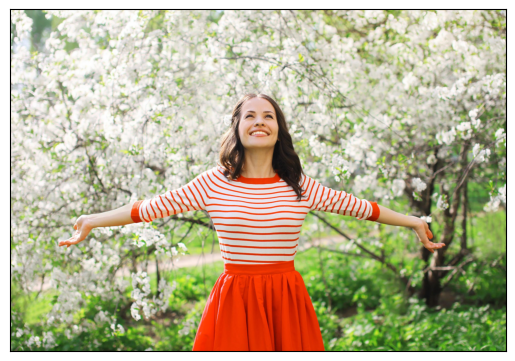

In [163]:
plt.imshow(cv2.cvtColor(image_matrix, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
#openCV reads image as BGR, and to return to RGB, convert it
plt.show()

In [164]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      extension = pathlib.Path(image_path).suffix[1:]
      img = cv2.imread(image_path)
      if extension not in image_exts:
        print(f'Unsupported Image Extension: {image_path}')
        os.remove(image_path)
    except Exception as e:
      print(f"Issue with image {image_path}")
      os.remove(image_path)

In [165]:
# tf.keras.utils.image_dataset_from_directory??
#Default batch_size=32, image_size=(256,256), shuffles=True

In [166]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 305 files belonging to 2 classes.


In [167]:
data_iterator = data.as_numpy_iterator()

In [168]:
batch = data_iterator.next() #Get the next batch from the iterator

In [169]:
print("{}: Batch of {}, Height of {}, Width of {}, channels of {}".format(batch[0].shape,
                     batch[0].shape[0],
                     batch[0].shape[1],
                     batch[0].shape[2],
                     batch[0].shape[3]))
print(batch[1]) #Label of happy or sad for each images

#class 1 = SAD
#class 0 = HAPPY

(32, 256, 256, 3): Batch of 32, Height of 256, Width of 256, channels of 3
[0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0]


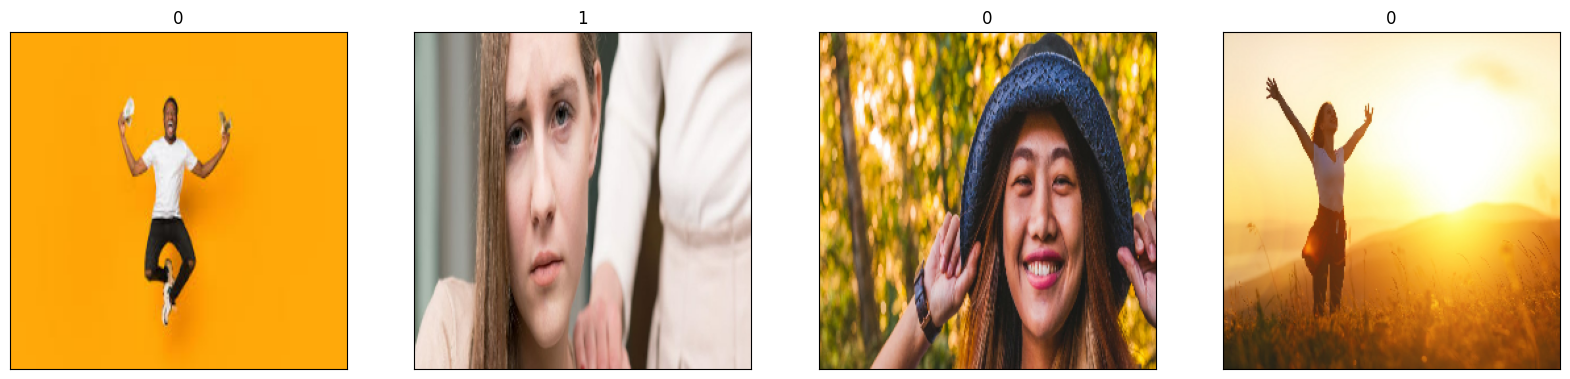

In [170]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].set_title(batch[1][idx])
  ax[idx].set_xticks([])
  ax[idx].set_yticks([])

In [171]:
#Divide every x value in the dataset by 255 to scale it. Leave the value of y alone to be 0 or 1 by using the map and lambda function.
data = data.map(lambda x, y: (x/255, y)) 

In [172]:
scaled_iterator = data.as_numpy_iterator()

In [173]:
batch = scaled_iterator.next()

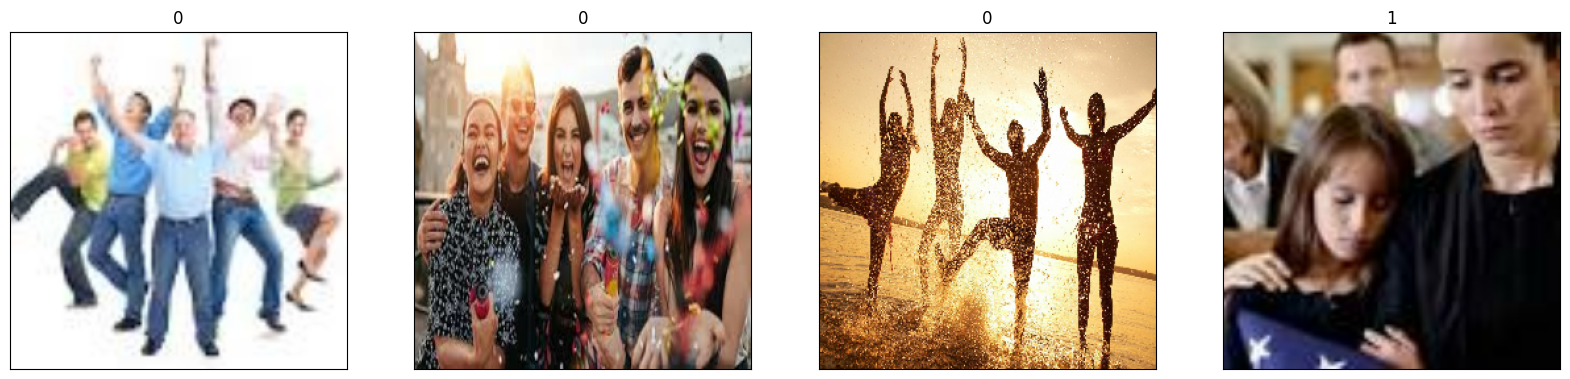

In [174]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].set_title(batch[1][idx])
  ax[idx].set_xticks([])
  ax[idx].set_yticks([])
# If there is a black image, you would have to rerun your data pipeline as you might have divided pixel value by 255 twice.

In [175]:
len(data)

10

In [176]:
train_size = int(len(data)*0.7)
valid_size = int(len(data)*0.2) + 1
test_size = int(len(data)*0.1) + 1

In [177]:
train_size + valid_size + test_size

12

In [178]:
train = data.take(train_size)
valid = data.skip(train_size).take(valid_size) #Skip the training data and take the size of the valid data
test = data.skip(train_size + valid_size).take(test_size) #Skip the traning and valid data and take the size of the test data

In [179]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, padding='Same', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, padding='Same', activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, padding='Same', activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [180]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [181]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 32, 32, 16)       

In [182]:
logdir = 'logs'

In [183]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [184]:
history = model.fit(train, epochs=20, validation_data=valid, callbacks=[tensorboard_callback])

Epoch 1/20


7/7 [==============================] - 17s 2s/step - loss: 1.1851 - accuracy: 0.4821 - val_loss: 0.6225 - val_accuracy: 0.7407
Epoch 2/20
7/7 [==============================] - 17s 2s/step - loss: 0.6045 - accuracy: 0.6696 - val_loss: 0.5153 - val_accuracy: 0.7901
Epoch 3/20
7/7 [==============================] - 18s 2s/step - loss: 0.5021 - accuracy: 0.7634 - val_loss: 0.4670 - val_accuracy: 0.8395
Epoch 4/20
7/7 [==============================] - 19s 2s/step - loss: 0.4263 - accuracy: 0.8259 - val_loss: 0.3435 - val_accuracy: 0.8519
Epoch 5/20
7/7 [==============================] - 22s 3s/step - loss: 0.3555 - accuracy: 0.8527 - val_loss: 0.2809 - val_accuracy: 0.9012
Epoch 6/20
7/7 [==============================] - 20s 3s/step - loss: 0.2913 - accuracy: 0.9152 - val_loss: 0.2109 - val_accuracy: 0.9506
Epoch 7/20
7/7 [==============================] - 21s 3s/step - loss: 0.2323 - accuracy: 0.9330 - val_loss: 0.1946 - val_accuracy: 0.9506
Epoch 8/20
7/7 [=============================

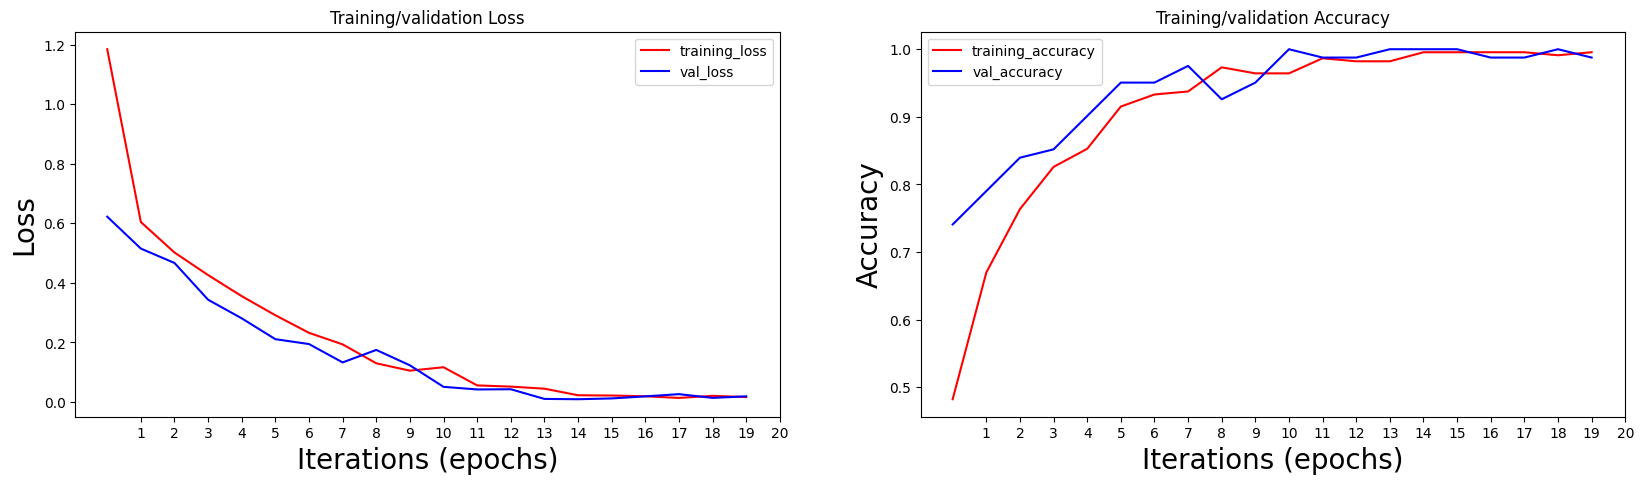

In [185]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title("Training/validation Loss")
ax[0].plot(history.history['loss'], label='training_loss', color='red')
ax[0].plot(history.history['val_loss'], label='val_loss', color='blue')
ax[0].set_xlabel("Iterations (epochs)", fontsize=20)
ax[0].set_ylabel("Loss", fontsize=20)
ax[0].set_xticks(range(1, 21))
ax[0].legend()

ax[1].set_title("Training/validation Accuracy")
ax[1].plot(history.history['accuracy'], label='training_accuracy', color='red')
ax[1].plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax[1].set_xlabel("Iterations (epochs)", fontsize=20)
ax[1].set_ylabel("Accuracy", fontsize=20)
ax[1].set_xticks(range(1, 21))
ax[1].legend()
plt.show()

In [186]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [187]:
for batch in test.as_numpy_iterator(): 
  X, y = batch
  yhat = model.predict(X)
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)

In [188]:
print(f"Precision: {precision.result()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}")

Precision: 0.0, Recall: 0.0, Accuracy: 0.0


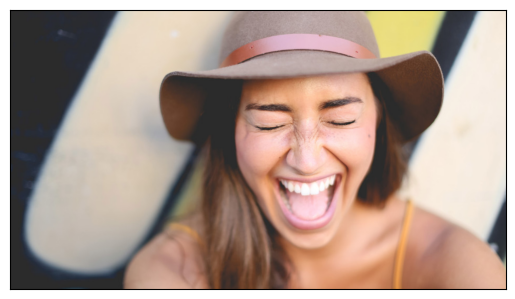

In [189]:
img = cv2.imread('happytest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

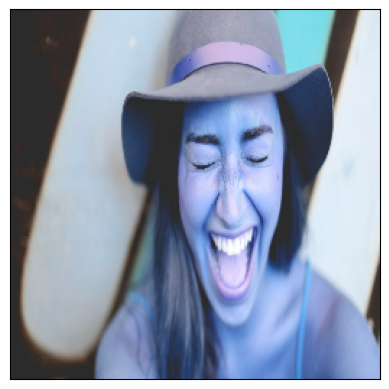

In [190]:
resized_img = tf.image.resize(img, (256,256))
plt.imshow(resized_img.numpy().astype(int))
plt.xticks([])
plt.yticks([])
plt.show()

In [191]:
resized_img.shape

TensorShape([256, 256, 3])

In [192]:
np.expand_dims(resized_img, 0).shape

(1, 256, 256, 3)

In [193]:
yhat = model.predict(np.expand_dims(resized_img/255, 0))

1/1 [==============================] - 0s 317ms/step


In [194]:
yhat

array([[0.1452708]], dtype=float32)

In [195]:
if yhat > 0.5:
  print("Our predicted class is sad")
else:
  print("Our predicted class is happy")

Our predicted class is happy


In [196]:
model.save(os.path.join('models', 'imageclassifier.keras'))

In [197]:
new_model = load_model(os.path.join('models', 'imageclassifier.keras'))

In [198]:
yhat_new = new_model.predict(np.expand_dims(resized_img/255, 0))

1/1 [==============================] - 0s 273ms/step


In [199]:
if yhat_new > 0.5:
  print("Our predicted class is sad")
else:
  print("Our predicted class is happy")

Our predicted class is happy
